In [1]:
%pylab inline
import datetime
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import string
import seaborn as sns
from operator import truediv

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.io.excel.read_excel('/Users/arjun/Google Drive/MLCE/Data from Amy/170309_Rational_promoter_assay.xlsx',index_col = 0)
df1.index = range(len(df1))
df1.index.name = 'Time'
df1.columns.name = 'Well_name'
# df_truncated=df1[40:100]


In [3]:
df2=pd.rolling_mean(df1,8,center=True)
# df2=pd.rolling_mean(df_truncated,8,center=True)
df2 = df2.stack().reset_index()
df2 = df2.rename(columns = {0 : "OD_value"})
df2['Well_row'] = df2['Well_name'].apply(lambda well: well[0])
df2['Well_column'] = df2['Well_name'].apply(lambda well: int(well[1:]))
len(df2)

C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=8,center=True).mean()
  if __name__ == '__main__':


13056

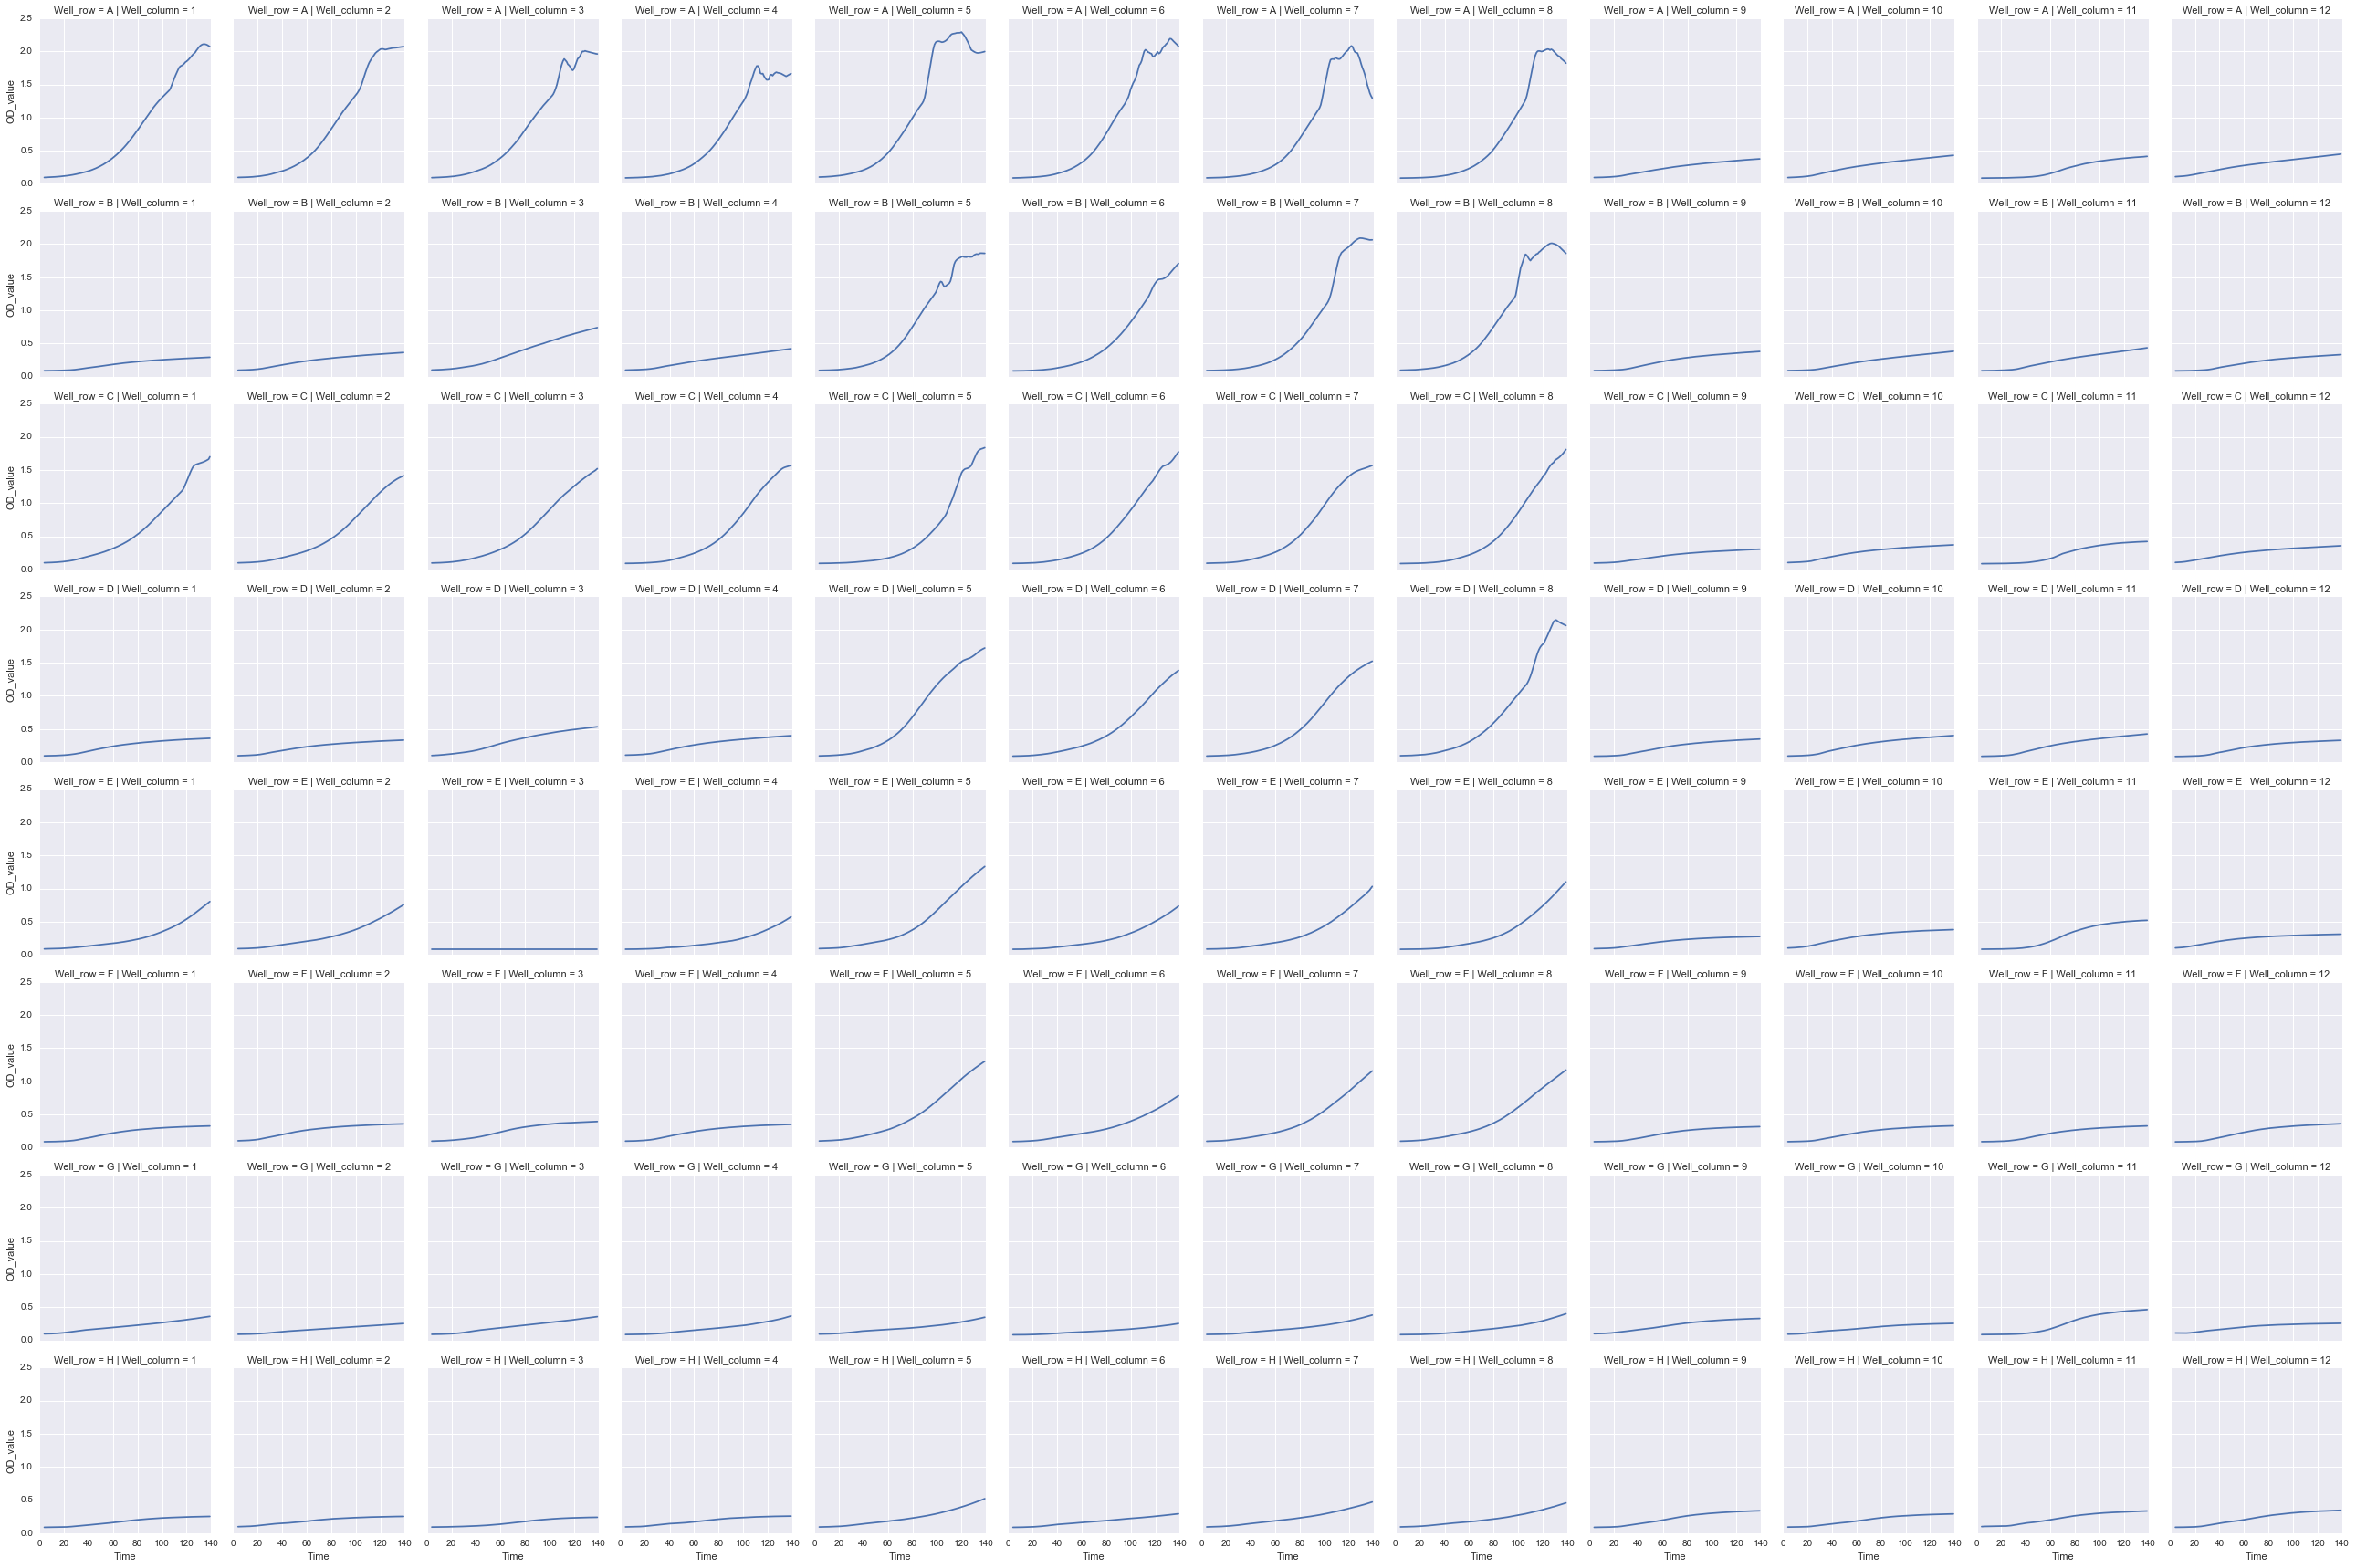

In [4]:
data = df2
x = "Time"
y = "OD_value"

row = 'Well_row'
column = 'Well_column'

grid = sns.FacetGrid(data, col = column, row = row)
grid = grid.map(plt.plot, x, y)

In [5]:
def calculate_maxV(dataframe, cutoff_value, num_of_datapoints, axes):
    x = axes[0]
    y = axes[1]
    
    # convert values > cutoff_value to NaN in dataframe.
    temp_df = dataframe.where(dataframe['OD_value'] <= cutoff_value)
    
    # sort by Well_name and time point
    temp_df.sort_values(['Well_name', 'Time'], inplace = True)
    
    # calculate difference between each value (value at first timepoint will become NaN)
    temp_df['OD_change'] = temp_df['OD_value'] - temp_df['OD_value'].shift(periods = num_of_datapoints)
    
    # calculate slopes
    temp_df['Slope'] = temp_df['OD_change']/(num_of_datapoints)*6
    slopes = temp_df
    
    # Since NaNs were introduced into some columns, integers were converted to floats (I'm not sure why this
    # happens). So, I have to get rid of those rows and convert the columns back into integers
    slopes.dropna(inplace = True)
    #slopes[y] = slopes[y].astype(int)    
    
    # calculate MaxV
    # select just DNA binding domain, activation domain and slope columns
    max_slope = temp_df[[x, y,'Slope']]
    
    # group by the DNA binding domain and activation domain columns, and then just keep the maximum slope
    max_slope = max_slope.groupby([x, y]).max().reset_index()
    

    
    # calculate slope by finding maximum (non-negative) rolling mean value and divide by num_of_datapoints
    #df = pd.rolling_mean(df, num_of_datapoints).max(axis=0)/num_of_datapoints*60
    
    return slopes, max_slope

In [6]:
"""
This is not completely ideal, it would be nice to fit the curves and then figure out the maximum growth rate from
there.

Anyhow, this function calculates the maximum slope. Then outputs two new dataframe containing the slopes and the
maximum slope for each pair of binders.

To use: input the starting dataframe, the 'cutoff' value -- the O.D. above which the data is ignored -- and the
step size for computing each slope.
"""


data_used = df2
cutoff = 1.5
step_size = 5
axes = ['Well_row', 'Well_column']
time_window = list(range(5, 80))

data_slopes, data_max_slope = calculate_maxV(data_used, cutoff, step_size, axes)

slopes_truncated = data_slopes.loc[data_slopes['Time'].isin(time_window)]
slopes_truncated_max = slopes_truncated[['Well_row', 'Well_column','Slope']]
slopes_truncated_max = slopes_truncated_max.groupby(['Well_row', 'Well_column']).max().reset_index()   


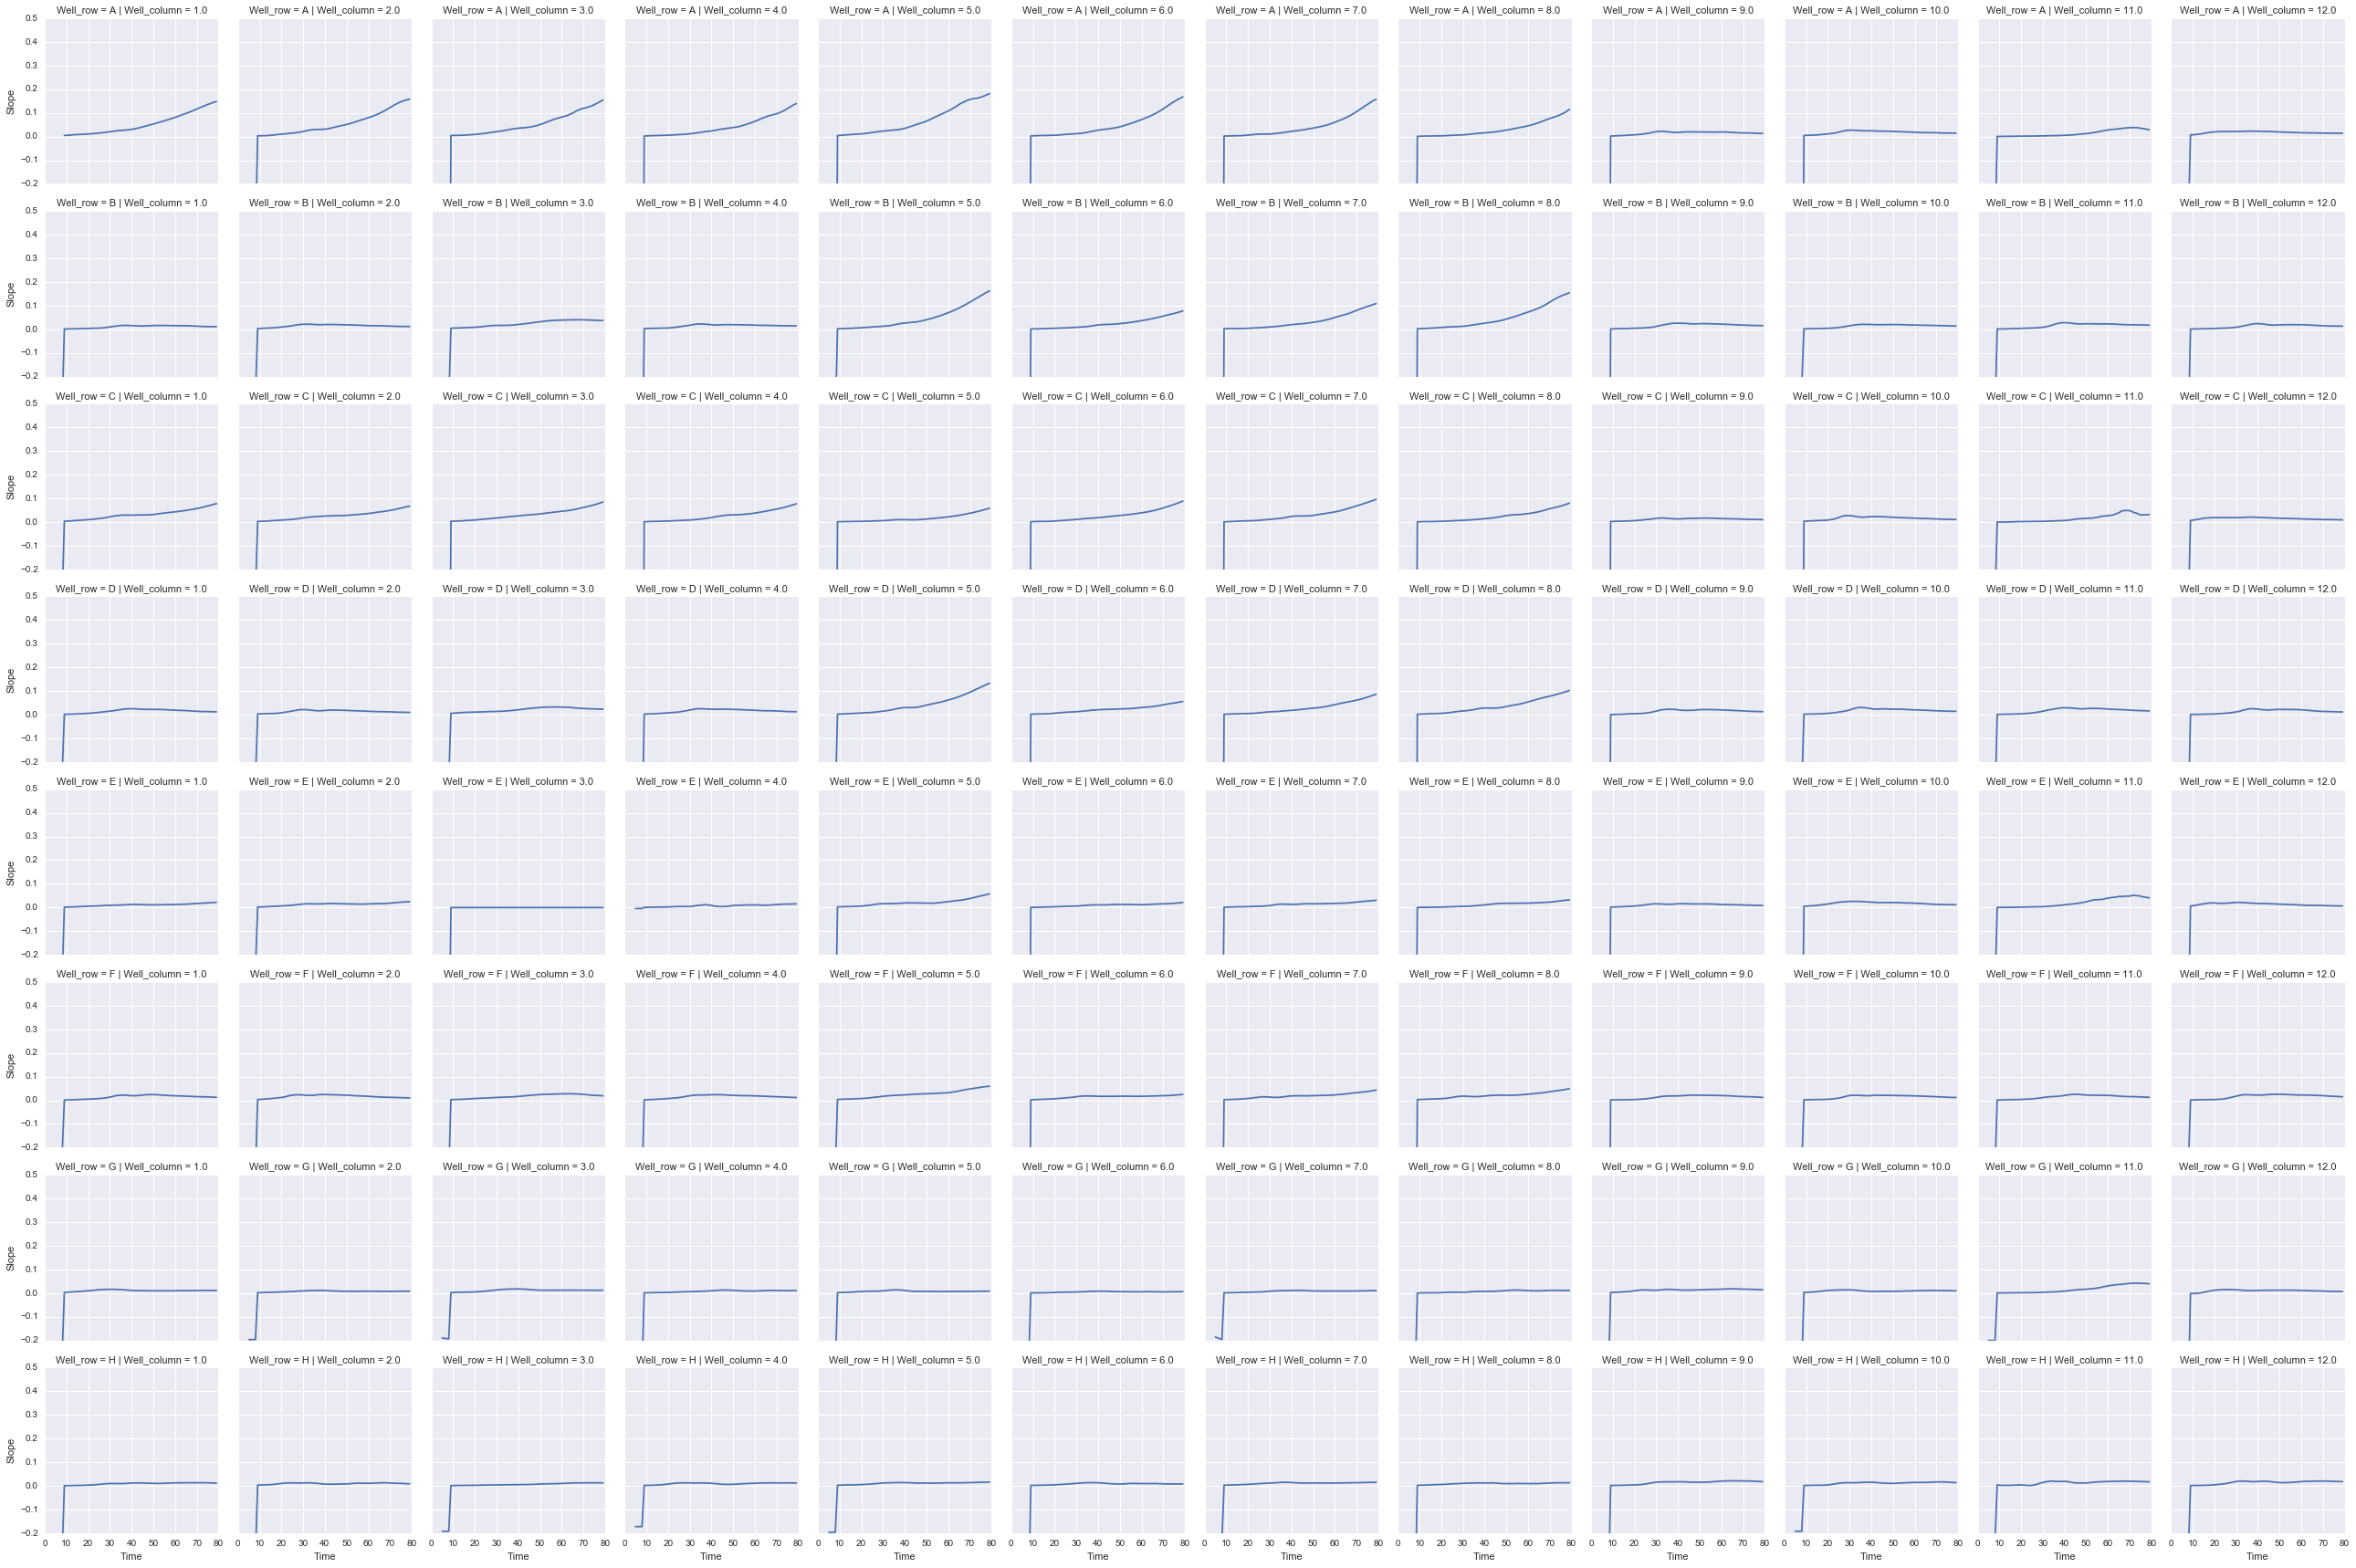

In [7]:
# data= data_slopes
data = slopes_truncated
x = "Time"
y = "Slope"

row = 'Well_row'
column = 'Well_column'

grid = sns.FacetGrid(data, col = column, row = row, ylim = (-0.2, 0.5))
grid = grid.map(plt.plot, x, y)

In [9]:
# max_slope_pivot = data_max_slope.pivot('Well_row', 'Well_column', 'Slope')
max_slope_pivot = slopes_truncated_max.pivot('Well_row', 'Well_column', 'Slope')
# plot = sns.heatmap(max_slope_pivot)
# fig = plot.get_figure()
max_slope_pivot

Well_column,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Well_row,,,,,,,,,,,,
A,0.14775,0.15750,0.15420,0.13935,0.18090,0.16785,0.15690,0.11460,0.02220,0.02700,0.03810,0.02280
B,0.01665,0.02145,0.04020,0.02235,0.16245,0.07740,0.10875,0.15405,0.02580,0.02100,0.02790,0.02385
C,0.07770,0.06690,0.08445,0.07695,0.05850,0.08820,0.09585,0.08010,0.01710,0.02745,0.04875,0.02085
D,0.02565,0.02190,0.03285,0.02565,0.13320,0.05595,0.08670,0.10275,0.02370,0.03090,0.02985,0.02610
E,0.02220,0.02460,0.00000,0.01545,0.05760,0.02130,0.03090,0.03270,0.01635,0.02625,0.05205,0.02175
F,0.02430,0.02430,0.02775,0.02385,0.05970,0.02475,0.04320,0.04875,0.02175,0.02145,0.02535,0.02535
G,0.01590,0.01125,0.01725,0.01260,0.01365,0.00795,0.01140,0.01260,0.01770,0.01365,0.04185,0.01470
H,0.01290,0.01275,0.01275,0.01260,0.01560,0.01335,0.01470,0.01305,0.02085,0.01650,0.01980,0.02025


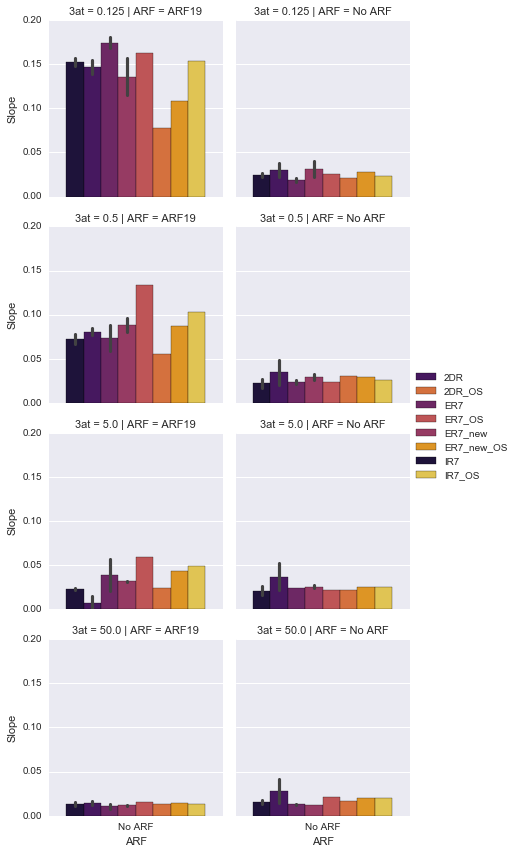

In [34]:
slopes_truncated_max['Col'] = [1,2]*8 + [1]*8 + [1,2]*8 + [1]*8 + [1,2]*8 + [1]*8 + [1,2]*8 + [1]*8
slopes_truncated_max['ARF'] = ['ARF19']*8 + ['No ARF']*8 + ['ARF19']*4 + ['No ARF']*4 + ['ARF19']*8 + ['No ARF']*8 + ['ARF19']*4 + ['No ARF']*4 + ['ARF19']*8 + ['No ARF']*8 + ['ARF19']*4 + ['No ARF']*4 + ['ARF19']*8 + ['No ARF']*8 + ['ARF19']*4 + ['No ARF']*4
slopes_truncated_max['promoter'] = ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2 + ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2+ ['ER7_new_OS','IR7_OS','2DR_OS','ER7_OS','ER7_OS','2DR_OS','ER7_new_OS','IR7_OS'] + ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2 + ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2+ ['ER7_new_OS','IR7_OS','2DR_OS','ER7_OS','ER7_OS','2DR_OS','ER7_new_OS','IR7_OS'] + ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2 + ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2+ ['ER7_new_OS','IR7_OS','2DR_OS','ER7_OS','ER7_OS','2DR_OS','ER7_new_OS','IR7_OS'] + ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2 + ['IR7']*2 + ['2DR']*2 + ['ER7']*2 + ['ER7_new']*2+ ['ER7_new_OS','IR7_OS','2DR_OS','ER7_OS','ER7_OS','2DR_OS','ER7_new_OS','IR7_OS']
slopes_truncated_max['3at'] = [0.125]*24 + [0.5]*24 + [5]*24 + [50]*24

#plotting the raw data
g = sns.FacetGrid(slopes_truncated_max, col="ARF",  row="3at")
g = g.map(sns.barplot,'ARF', 'Slope','promoter',palette = 'inferno').add_legend()


In [37]:
#subsetting and ordering data

slopes_arf19 = slopes_truncated_max[slopes_truncated_max['ARF']=='ARF19']
slopes_noarf = slopes_truncated_max[slopes_truncated_max['ARF']=='No ARF']

slopes_arf19_IR7 = slopes_arf19[slopes_arf19['promoter']=='IR7']
slopes_arf19_ER7_new = slopes_arf19[slopes_arf19['promoter']=='ER7_new']
slopes_arf19_ER7 = slopes_arf19[slopes_arf19['promoter']=='ER7']
slopes_arf19_2DR = slopes_arf19[slopes_arf19['promoter']=='2DR']
slopes_arf19_IR7_OS = slopes_arf19[slopes_arf19['promoter']=='IR7_OS']
slopes_arf19_ER7_new_OS = slopes_arf19[slopes_arf19['promoter']=='ER7_new_OS']
slopes_arf19_ER7_OS = slopes_arf19[slopes_arf19['promoter']=='ER7_OS']
slopes_arf19_2DR_OS = slopes_arf19[slopes_arf19['promoter']=='2DR_OS']

slopes_noarf_IR7 = slopes_noarf[slopes_noarf['promoter']=='IR7']
slopes_noarf_ER7_new = slopes_noarf[slopes_noarf['promoter']=='ER7_new']
slopes_noarf_ER7 = slopes_noarf[slopes_noarf['promoter']=='ER7']
slopes_noarf_2DR = slopes_noarf[slopes_noarf['promoter']=='2DR']
slopes_noarf_IR7_OS = slopes_noarf[slopes_noarf['promoter']=='IR7_OS']
slopes_noarf_ER7_new_OS = slopes_noarf[slopes_noarf['promoter']=='ER7_new_OS']
slopes_noarf_ER7_OS = slopes_noarf[slopes_noarf['promoter']=='ER7_OS']
slopes_noarf_2DR_OS = slopes_noarf[slopes_noarf['promoter']=='2DR_OS']

slopes_arf19_IR7.sort('3at')
slopes_arf19_ER7_new.sort('3at')
slopes_arf19_ER7.sort('3at')
slopes_arf19_2DR.sort('3at')
slopes_arf19_IR7_OS.sort('3at')
slopes_arf19_ER7_new_OS.sort('3at')
slopes_arf19_ER7_OS.sort('3at')
slopes_arf19_2DR_OS.sort('3at')

slopes_noarf_IR7.sort('3at')
slopes_noarf_ER7_new.sort('3at')
slopes_noarf_ER7.sort('3at')
slopes_noarf_2DR.sort('3at')
slopes_noarf_IR7_OS.sort('3at')
slopes_noarf_ER7_new_OS.sort('3at')
slopes_noarf_ER7_OS.sort('3at')
slopes_noarf_2DR_OS.sort('3at')

C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: sort(columns=....) is deprecated, use so

,Well_row,Well_column,Slope,Col,ARF,promoter,3at
21,B,10.0,0.02100,1,No ARF,2DR_OS,0.125
45,D,10.0,0.03090,1,No ARF,2DR_OS,0.500
69,F,10.0,0.02145,1,No ARF,2DR_OS,5.000
93,H,10.0,0.01650,1,No ARF,2DR_OS,50.000


C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

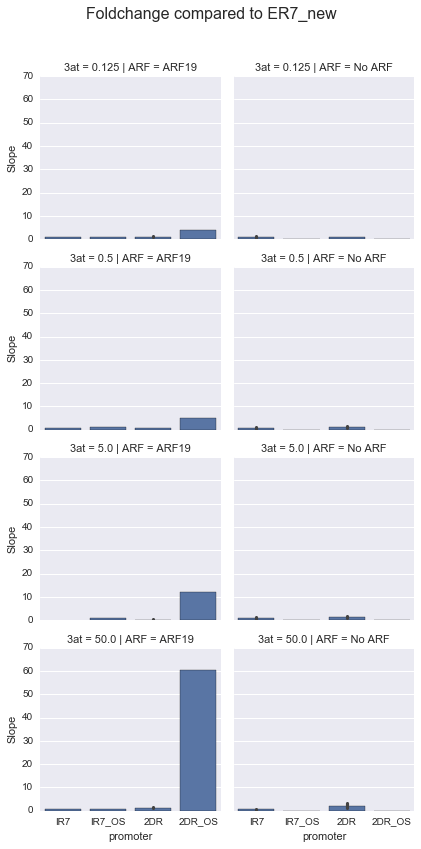

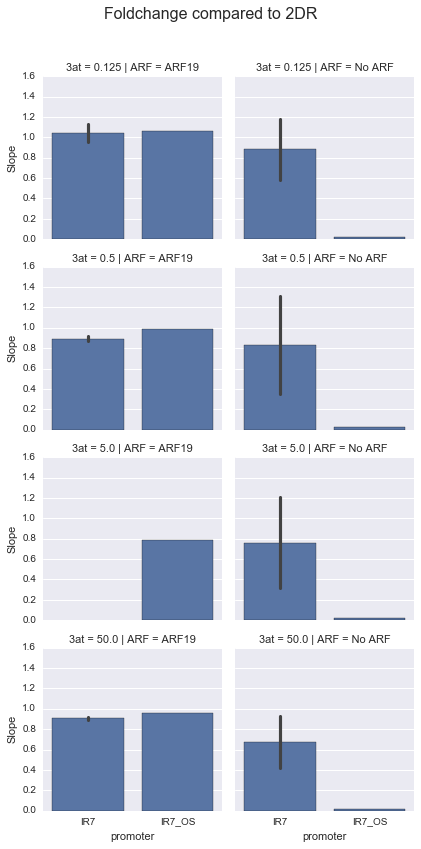

In [38]:
#Foldchange between IR7 and DR2 by ER7_new

fc_ie_arf19 = slopes_arf19_IR7
fc_de_arf19 = slopes_arf19_2DR
fc_id_arf19 = slopes_arf19_IR7
fc_ie_arf19_OS = slopes_arf19_IR7_OS
fc_de_arf19_OS = slopes_arf19_2DR_OS
fc_id_arf19_OS = slopes_arf19_IR7_OS

fc_ie_noarf = slopes_noarf_IR7
fc_de_noarf = slopes_noarf_2DR
fc_id_noarf = slopes_noarf_IR7
fc_ie_noarf_OS = slopes_noarf_IR7_OS
fc_de_noarf_OS = slopes_noarf_2DR_OS
fc_id_noarf_OS = slopes_noarf_IR7_OS

fc_ie_arf19['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7['Slope'], slopes_arf19_ER7_new['Slope'])]
fc_de_arf19['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_2DR['Slope'], slopes_arf19_ER7_new['Slope'])]
fc_id_arf19['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7['Slope'], slopes_arf19_2DR['Slope'])]
fc_ie_arf19_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7_OS['Slope'], slopes_arf19_ER7_new_OS['Slope'])]
fc_de_arf19_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_2DR_OS['Slope'], slopes_arf19_ER7_new_OS['Slope'])]
fc_id_arf19_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7_OS['Slope'], slopes_arf19_2DR_OS['Slope'])]


fc_ie_noarf['Slope'] = [float(c)/t for c,t in zip(slopes_noarf_IR7['Slope'], slopes_noarf_ER7_new['Slope'])]
fc_de_noarf['Slope'] = [float(c)/t for c,t in zip(slopes_noarf_2DR['Slope'], slopes_noarf_ER7_new['Slope'])]
fc_id_noarf['Slope'] = [float(c)/t for c,t in zip(slopes_noarf_IR7['Slope'], slopes_noarf_2DR['Slope'])]
fc_ie_arf19_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7_OS['Slope'], slopes_arf19_ER7_new_OS['Slope'])]
fc_de_arf19_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_2DR_OS['Slope'], slopes_arf19_ER7_new_OS['Slope'])]
fc_id_arf19_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7_OS['Slope'], slopes_arf19_2DR_OS['Slope'])]


fc_ie = fc_ie_arf19.append(fc_ie_noarf).append(fc_ie_arf19_OS).append(fc_ie_noarf_OS)
fc_de = fc_de_arf19.append(fc_de_noarf).append(fc_de_arf19_OS).append(fc_de_noarf_OS)
fc_e = fc_ie.append(fc_de)

fc_id = fc_id_arf19.append(fc_id_noarf).append(fc_id_arf19_OS).append(fc_id_noarf_OS)


# g = sns.FacetGrid(fc_e, col="ARF",  row="3at")
# g = g.map(sns.barplot,'promoter', 'Slope')
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Foldchange compared to ER7_new', fontsize=16)

# g2 = sns.FacetGrid(fc_id, col="ARF",  row="3at")
# g2 = g2.map(sns.barplot,'promoter', 'Slope')
# g2.fig.subplots_adjust(top=0.9)
# g2.fig.suptitle('Foldchange compared to 2DR', fontsize=16)

g = sns.FacetGrid(fc_e, col="ARF",  row="3at")
g = g.map(sns.barplot,'promoter', 'Slope')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Foldchange compared to ER7_new', fontsize=16)

g2 = sns.FacetGrid(fc_id, col="ARF",  row="3at")
g2 = g2.map(sns.barplot,'promoter', 'Slope')
g2.fig.subplots_adjust(top=0.9)
g2.fig.suptitle('Foldchange compared to 2DR', fontsize=16)


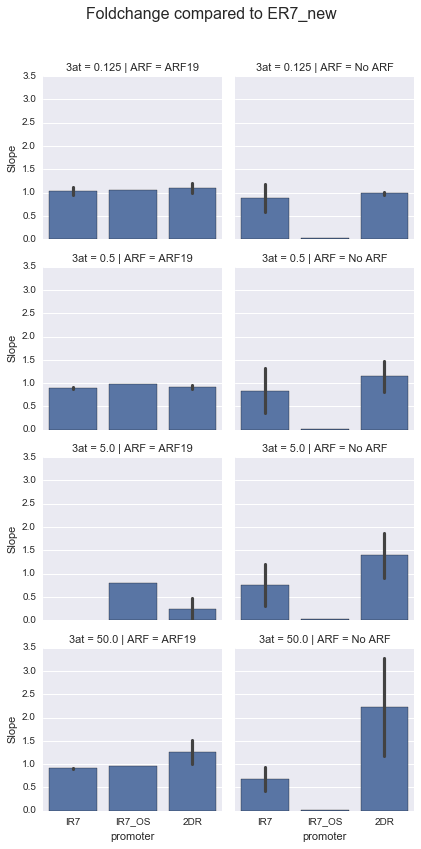

In [44]:
g = sns.FacetGrid(fc_e[fc_e['promoter']!='2DR_OS'], col="ARF",  row="3at")
g = g.map(sns.barplot,'promoter', 'Slope')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Foldchange compared to ER7_new', fontsize=16)


In [39]:
#Normalizing to No ARF

slopes_arf19_IR7_normalized = slopes_arf19_IR7
slopes_arf19_ER7_new_normalized = slopes_arf19_ER7_new
slopes_arf19_ER7_normalized = slopes_arf19_ER7
slopes_arf19_2DR_normalized = slopes_arf19_2DR

slopes_arf19_IR7_normalized_OS = slopes_arf19_IR7_OS
slopes_arf19_ER7_new_normalized_OS = slopes_arf19_ER7_new_OS
slopes_arf19_ER7_normalized_OS = slopes_arf19_ER7_OS
slopes_arf19_2DR_normalized_OS = slopes_arf19_2DR_OS

slopes_arf19_IR7_normalized['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7['Slope'], slopes_noarf_IR7['Slope'])]
slopes_arf19_ER7_new_normalized['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_ER7_new['Slope'], slopes_noarf_ER7_new['Slope'])]
slopes_arf19_ER7_normalized['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_ER7['Slope'], slopes_noarf_ER7['Slope'])]
slopes_arf19_2DR_normalized['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_2DR['Slope'], slopes_noarf_2DR['Slope'])]

slopes_arf19_IR7_normalized_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_IR7_OS['Slope'], slopes_noarf_IR7_OS['Slope'])]
slopes_arf19_ER7_new_normalized_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_ER7_new_OS['Slope'], slopes_noarf_ER7_new_OS['Slope'])]
slopes_arf19_ER7_normalized_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_ER7_OS['Slope'], slopes_noarf_ER7_OS['Slope'])]
slopes_arf19_2DR_normalized_OS['Slope'] = [float(c)/t for c,t in zip(slopes_arf19_2DR_OS['Slope'], slopes_noarf_2DR_OS['Slope'])]


C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arjun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

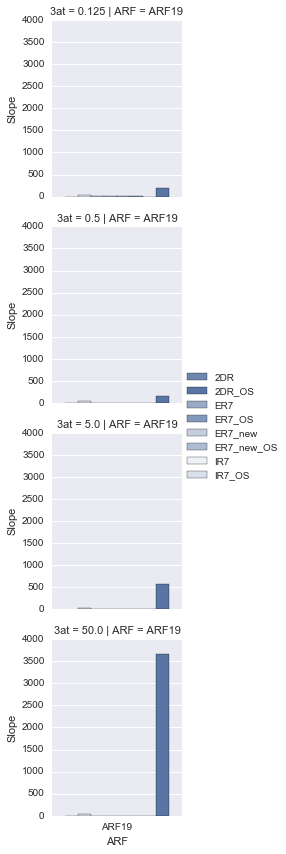

In [40]:
#plotting the Normalized data

slopes_normalized = slopes_arf19_IR7_normalized.append(slopes_arf19_IR7_normalized_OS).append(slopes_arf19_ER7_new_normalized).append(slopes_arf19_ER7_new_normalized_OS).append(slopes_arf19_ER7_normalized).append(slopes_arf19_ER7_normalized_OS).append(slopes_arf19_2DR_normalized).append(slopes_arf19_2DR_normalized_OS)
    
# g = sns.FacetGrid(slopes_normalized, col="ARF",  row="3at")
g = sns.FacetGrid(slopes_normalized, col="ARF",  row="3at")
g = g.map(sns.barplot,'ARF', 'Slope','promoter').add_legend()

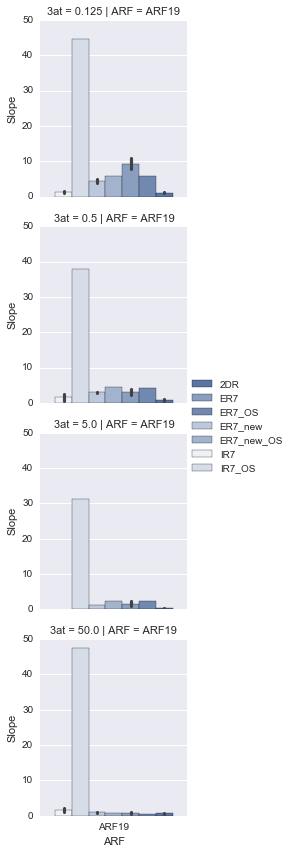

In [43]:
g = sns.FacetGrid(slopes_normalized[slopes_normalized['promoter']!='2DR_OS'], col="ARF",  row="3at")
g = g.map(sns.barplot,'ARF', 'Slope','promoter').add_legend()